# Bayesian NMF

We will try to set up a MF workflow for the AMS data for Krakow, first we define our matrix factorization model, coming from the PyMC documentation. Notice that here `PMF` refers to Probabilistic Matrix Factorization instead of Positive Matrix Factorization as known in the air quality literature

In [2]:
import logging
import time

import scipy as sp
import theano
import pandas as pd
import numpy as np
import pymc3 as pm

from matplotlib import pyplot as plt

plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.4


In [3]:
# Enable on-the-fly graph computations, but ignore
# absence of intermediate test values.
theano.config.compute_test_value = "ignore"

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)


class PMF:
    """Probabilistic Matrix Factorization model using pymc3."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(1, 5)):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info("building the PMF model")
        with pm.Model() as pmf:
            PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
            U = PositiveNormal(
                "U",
                mu=0,
                tau=self.alpha_u,
                shape=(n, dim)
            )
            V = PositiveNormal(
                "V",
                mu=0,
                tau=self.alpha_v,
                shape=(m, dim)
            )
            R = pm.Normal(
                "R", mu=(U @ V.T)[~nan_mask], tau=self.alpha, observed=self.data[~nan_mask]
            )

        logging.info("done building the PMF model")
        self.model = pmf

    def __str__(self):
        return self.name
    
def _find_map(self):
    """Find mode of posterior using L-BFGS-B optimization."""
    tstart = time.time()
    with self.model:
        logging.info("finding PMF MAP using L-BFGS-B optimization...")
        self._map = pm.find_MAP(method="L-BFGS-B")

    elapsed = int(time.time() - tstart)
    logging.info("found PMF MAP in %d seconds" % elapsed)
    return self._map


def _map(self):
    try:
        return self._map
    except:
        return self.find_map()


# Update our class with the new MAP infrastructure.
PMF.find_map = _find_map
PMF.map = property(_map)

# Draw MCMC samples.
def _draw_samples(self, **kwargs):
    kwargs.setdefault("chains", 1)
    with self.model:
        self.trace = pm.sample(**kwargs)


# Update our class with the sampling infrastructure.
PMF.draw_samples = _draw_samples


def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.random.normal(R, self.std)
    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


PMF.predict = _predict

# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)  # indicator for missing values
    N = I.sum()  # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N  # mean squared error
    return np.sqrt(mse)  # RMSE

In [4]:
krakov_df= pd.read_csv("../data/observations/krakov.csv",index_col=0,parse_dates=True)
krakov_df

,12,13,15,16,17,18,24,25,26,27,...,111,112,113,114,115,116,117,118,119,120
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-08 15:30:00,-0.003523,0.042046,0.341372,0.018782,0.117385,0.469542,0.004058,0.026456,0.081814,0.046262,...,0.026082,0.019182,0.021737,0.015301,0.041879,0.016196,0.027027,0.014819,0.034483,0.012276
2018-01-08 16:00:00,-0.150227,-0.008195,0.022245,0.003168,0.019797,0.079189,0.000597,-0.013850,0.063849,0.084627,...,0.016773,0.021456,0.019668,0.017158,0.043933,0.014488,0.018494,0.020011,0.025490,0.019865
2018-01-08 16:30:00,-0.073763,-0.012552,0.004427,0.010750,0.067189,0.268756,0.004334,0.007637,0.104142,-0.009910,...,0.023564,0.006726,0.037375,0.008389,0.036188,0.011742,0.017189,0.013873,0.039163,0.019338
2018-01-08 17:00:00,-0.118308,0.038575,0.088323,0.019541,0.122133,0.488532,-0.003255,0.020286,0.061825,0.127102,...,0.019575,0.023191,0.015848,0.012163,0.043554,0.012909,0.020370,0.013007,0.028607,0.021247
2018-01-08 17:30:00,-0.120782,0.000762,0.020262,0.024266,0.151665,0.606660,0.005013,0.022284,0.086115,0.168124,...,0.015858,0.010879,0.032698,0.011473,0.044271,0.017018,0.012387,0.009406,0.036408,0.017181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-10 05:00:00,0.027184,0.050378,0.293053,0.109473,0.684207,2.736828,0.019358,0.033263,0.118950,0.379278,...,0.022693,0.013698,0.013684,0.011438,0.042559,0.023342,0.015661,0.004957,0.032708,0.014308
2019-04-10 05:30:00,0.060938,0.090977,0.232242,0.108391,0.677442,2.709769,0.003126,0.051296,0.170406,0.410444,...,0.034125,0.013260,0.021385,0.006524,0.024382,0.006796,0.014281,0.007714,0.012998,0.024054
2019-04-10 06:00:00,-0.050615,0.038717,0.399933,0.098784,0.617403,2.469612,0.015264,0.049599,0.181920,0.611250,...,0.030354,0.011480,0.014770,0.020186,0.032451,0.002959,0.019330,0.016856,0.026634,0.018623


In [5]:
krakov_df.drop(["12","37"],axis=1,inplace=True)
krakov_df=krakov_df.resample("1h").mean()
krakov_df

,13,15,16,17,18,24,25,26,27,29,...,111,112,113,114,115,116,117,118,119,120
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-08 15:00:00,0.042046,0.341372,0.018782,0.117385,0.469542,0.004058,0.026456,0.081814,0.046262,0.338915,...,0.026082,0.019182,0.021737,0.015301,0.041879,0.016196,0.027027,0.014819,0.034483,0.012276
2018-01-08 16:00:00,-0.010374,0.013336,0.006959,0.043493,0.173972,0.002466,-0.003106,0.083995,0.037358,0.340448,...,0.020168,0.014091,0.028521,0.012774,0.040060,0.013115,0.017842,0.016942,0.032326,0.019601
2018-01-08 17:00:00,0.019669,0.054292,0.021904,0.136899,0.547596,0.000879,0.021285,0.073970,0.147613,0.418153,...,0.017717,0.017035,0.024273,0.011818,0.043912,0.014964,0.016378,0.011206,0.032507,0.019214
2018-01-08 18:00:00,0.002399,0.089813,0.028140,0.175874,0.703498,0.004756,0.042866,0.097930,0.291938,0.484303,...,0.021535,0.013947,0.019685,0.014751,0.049146,0.015329,0.030049,0.022139,0.032412,0.018580
2018-01-08 19:00:00,0.032840,0.165615,0.028399,0.177491,0.709964,0.010923,0.018421,0.092324,0.158711,0.553286,...,0.026437,0.012632,0.026246,0.013453,0.066393,0.016967,0.023685,0.024929,0.037867,0.026070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-10 03:00:00,0.055040,0.262020,0.128502,0.803139,3.212556,0.014173,0.055953,0.253336,0.426808,1.160214,...,0.030903,0.013312,0.023798,0.015876,0.048721,0.020926,0.022978,0.017736,0.025753,0.018239
2019-04-10 04:00:00,0.061371,0.473349,0.124479,0.777995,3.111979,0.015879,0.054982,0.189658,0.693440,1.119747,...,0.029888,0.014957,0.022898,0.016249,0.041682,0.017663,0.020925,0.019102,0.031185,0.015051
2019-04-10 05:00:00,0.070677,0.262648,0.108932,0.680825,2.723298,0.011242,0.042279,0.144678,0.394861,0.864049,...,0.028409,0.013479,0.017535,0.008981,0.033470,0.015069,0.014971,0.006335,0.022853,0.019181


In [4]:
    
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 4

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each movie. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Movielens dataset, this means we have D(2625), so for 5
# dimensions, we are sampling 13125 latent variables.
DIM = 11


pmf = PMF(krakov_df.values, DIM, ALPHA, std=0.05)

# Find MAP for PMF
pmf.find_map();

INFO:root:building the PMF model
INFO:root:done building the PMF model
INFO:root:finding PMF MAP using L-BFGS-B optimization...


INFO:root:found PMF MAP in 10 seconds


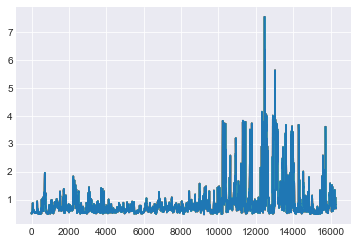

In [5]:
plt.plot(pmf.map["U"])

In [6]:
normalized_time = (np.array(krakov_df.index.astype(int)) - np.min(np.array(krakov_df.index.astype(int))))
normalized_time = normalized_time /(np.max(normalized_time))
first_ts=krakov_df.iloc[:,0].values

display(normalized_time)
display(first_ts)
display(first_ts[np.isnan(first_ts)])

valid_times=~np.isnan(first_ts)

input_time = normalized_time[valid_times]
input_ts=first_ts[valid_times]
display(input_time)
display(input_ts)

Z = normalized_time[~valid_times]
np.expand_dims(input_time,axis=1)

array([0.00000000e+00, 9.12408759e-05, 1.82481752e-04, ...,
       9.99817518e-01, 9.99908759e-01, 1.00000000e+00])

array([ 0.042046  , -0.01037391,  0.01966863, ...,  0.07067725,
        0.00622268,  0.18474056])

array([nan, nan, nan, ..., nan, nan, nan])

array([0.00000000e+00, 9.12408759e-05, 1.82481752e-04, ...,
       9.99817518e-01, 9.99908759e-01, 1.00000000e+00])

array([ 0.042046  , -0.01037391,  0.01966863, ...,  0.07067725,
        0.00622268,  0.18474056])

array([[0.00000000e+00],
       [9.12408759e-05],
       [1.82481752e-04],
       ...,
       [9.99817518e-01],
       [9.99908759e-01],
       [1.00000000e+00]])

In [16]:
import theano
import theano.tensor as tt
import theano.tensor.nlinalg

Xu = input_time[1::168]
Xu.shape

(49,)

In [17]:


class SparseLatent:
    def __init__(self, cov_func):
        self.cov = cov_func

    def prior(self, name, X, Xu):
        Kuu = self.cov(Xu)
        self.L = pm.gp.util.cholesky(pm.gp.util.stabilize(Kuu))

        self.v = pm.Normal(f"u_rotated_{name}", mu=0.0, sd=1.0, shape=len(Xu))
        self.u = pm.Deterministic(f"u_{name}", tt.dot(self.L, self.v))

        Kfu = self.cov(X, Xu)
        self.Kuiu = tt.slinalg.solve_upper_triangular(
            self.L.T, tt.slinalg.solve_lower_triangular(self.L, self.u)
        )
        self.mu = pm.Deterministic(f"mu_{name}", tt.dot(Kfu, self.Kuiu))
        return self.mu

    def conditional(self, name, Xnew, Xu):
        Ksu = self.cov(Xnew, Xu)
        mus = tt.dot(Ksu, self.Kuiu)
        tmp = tt.slinalg.solve_lower_triangular(self.L, Ksu.T)
        Qss = tt.dot(tmp.T, tmp)  # Qss = tt.dot(tt.dot(Ksu, tt.nlinalg.pinv(Kuu)), Ksu.T)
        Kss = self.cov(Xnew)
        Lss = pm.gp.util.cholesky(pm.gp.util.stabilize(Kss - Qss))
        mu_pred = pm.MvNormal(name, mu=mus, chol=Lss, shape=len(Xnew))
        return mu_pred


with pm.Model() as model:
   
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η ** 2 * pm.gp.cov.Matern52(1, ℓ)
    
    gp = SparseLatent(cov_func=cov)
     # initialize 100 inducing points with K-means
    # gp.util
    f = gp.prior("f", X=np.expand_dims(input_time,axis=1),Xu=np.expand_dims(Xu,1))
   
    y_ = pm.Normal("y", mu=f, tau=4, observed=input_ts)
    
    trace = pm.sample(1000,cores=1,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [u_rotated_f, η, ℓ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 868 seconds.
There were 127 divergences after tuning. Increase `target_accept` or reparameterize.
There were 349 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6785233133835523, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [24]:
with model:
   # μ_pred = gp.conditional("μ_pred", np.expand_dims(Z,axis=1), np.expand_dims(Xu,axis=1))

    samples= pm.sample_posterior_predictive(trace, var_names=["μ_pred"])

In [28]:
def plot_inducing_points(ax):
    yl = ax.get_ylim()
    yu = -np.subtract(*yl) * 0.025 + yl[0]
    ax.plot(Xu, np.full(Xu.shape, yu), "xk", label="Inducing Points")
    ax.legend(loc="upper left")


def get_quantiles(samples, quantiles=[2.5, 50, 97.5]):
    return [np.percentile(samples, p, axis=0) for p in quantiles]


def plot_mean(ax, mean_samples,Xnew):
    """Plots the median and 95% CI from samples of the mean

    Note that, although each individual GP exhibits a normal distribution at each point
    (by definition), we are sampling from a mixture of GPs defined by the posteriors of
    our hyperparameters. As such, we use percentiles rather than mean +/- stdev to
    represent the spread of predictions from our models.
    """
    l, m, u = get_quantiles(mean_samples)
    ax.plot(Xnew, m, "C0", label="Median")
    ax.fill_between(Xnew_, l, u, facecolor="C0", alpha=0.5, label="95% CI")

    ax.plot(Xnew, ynew, "--k", label="Mean Function")
    ax.plot(X, y, "C1.", label="Observed Means")
    ax.set_title("Mean Behavior")
    ax.legend(loc="upper left")


def plot_var(ax, var_samples):
    """Plots the median and 95% CI from samples of the variance"""
    if var_samples.squeeze().ndim == 1:
        ax.plot(Xnew, var_samples, "C0", label="Median")
    else:
        l, m, u = get_quantiles(var_samples)
        ax.plot(Xnew, m, "C0", label="Median")
        ax.fill_between(Xnew.flatten(), l, u, facecolor="C0", alpha=0.5, label="95% CI")
    ax.plot(Xnew, noise(signal(Xnew_)) ** 2, "--k", label="Noise Function")
    ax.plot(X, y_err ** 2, "C1.", label="Observed Variance")
    ax.set_title("Variance Behavior")
    ax.legend(loc="upper left")


def plot_total(ax, mean_samples, var_samples=None, bootstrap=True, n_boots=100):
    """Plots the overall mean and variance of the aggregate system

    We can represent the overall uncertainty via explicitly sampling the underlying normal
    distributrions (with `bootstrap=True`) or as the mean +/- the standard deviation from
    the Law of Total Variance. For systems with many observations, there will likely be
    little difference, but in cases with few observations and informative priors, plotting
    the percentiles will likely give a more accurate representation.
    """

    if (var_samples is None) or (var_samples.squeeze().ndim == 1):
        samples = mean_samples
        l, m, u = get_quantiles(samples)
        ax.plot(Xnew, m, "C0", label="Median")
    elif bootstrap:
        # Estimate the aggregate behavior using samples from each normal distribution in the posterior
        samples = (
            rng.normal(
                mean_samples.T[:, :, None],
                np.sqrt(var_samples).T[:, :, None],
                (*mean_samples.T.shape, n_boots),
            )
            .reshape(len(Xnew_), -1)
            .T
        )
        l, m, u = get_quantiles(samples)
        ax.plot(Xnew, m, "C0", label="Median")
    else:
        m = mean_samples.mean(axis=0)
        ax.plot(Xnew, m, "C0", label="Mean")
        sd = np.sqrt(mean_samples.var(axis=0) + var_samples.mean(axis=0))
        l, u = m - 2 * sd, m + 2 * sd

    ax.fill_between(Xnew.flatten(), l, u, facecolor="C0", alpha=0.5, label="Total 95% CI")

    ax.plot(Xnew, ynew, "--k", label="Mean Function")
    ax.plot(X_obs, y_obs_, "C1.", label="Observations")
    ax.set_title("Aggregate Behavior")
    ax.legend(loc="upper left")

NameError: name 'Xnew_' is not defined

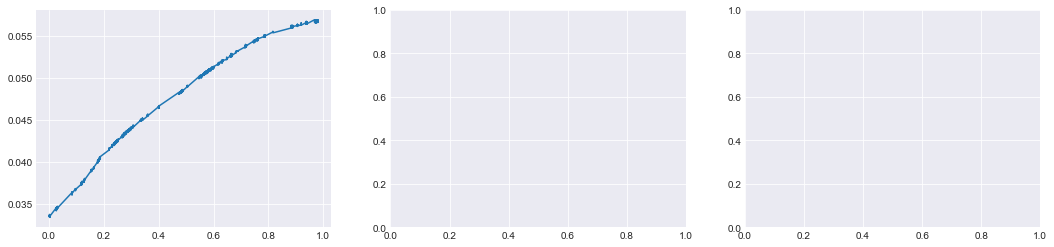

In [32]:
_, axs = plt.subplots(1, 3, figsize=(18, 4))
μ_samples = samples["μ_pred"]
plot_mean(ax=axs[0], mean_samples=μ_samples, Xnew=np.expand_dims(Z,axis=1))

In [ ]:
def eval_map(pmf_model, train, test):
    U = pmf_model.map["U"]
    V = pmf_model.map["V"]

    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)
    overfit = test_rmse - train_rmse

    # Print report.
    print("PMF MAP training RMSE: %.5f" % train_rmse)
    print("PMF MAP testing RMSE:  %.5f" % test_rmse)
    print("Train/test difference: %.5f" % overfit)

    return test_rmse


# Add eval function to PMF class.
PMF.eval_map = eval_map

# Evaluate PMF MAP estimates.
pmf_map_rmse = pmf.eval_map(train, test)
pmf_improvement = baselines["mom"] - pmf_map_rmse
print("PMF MAP Improvement:   %.5f" % pmf_improvement)

# Draw MCMC samples.
pmf.draw_samples(
    draws=500,
    tune=500,
)

def _norms(pmf_model, monitor=("U", "V"), ord="fro"):
    """Return norms of latent variables at each step in the
    sample trace. These can be used to monitor convergence
    of the sampler.
    """
    monitor = ("U", "V")
    norms = {var: [] for var in monitor}
    for sample in pmf_model.trace:
        for var in monitor:
            norms[var].append(np.linalg.norm(sample[var], ord))
    return norms


def _traceplot(pmf_model):
    """Plot Frobenius norms of U and V as a function of sample #."""
    trace_norms = pmf_model.norms()
    u_series = pd.Series(trace_norms["U"])
    v_series = pd.Series(trace_norms["V"])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    u_series.plot(kind="line", ax=ax1, grid=False, title=r"$\|U\|_{Fro}^2$ at Each Sample")
    v_series.plot(kind="line", ax=ax2, grid=False, title=r"$\|V\|_{Fro}^2$ at Each Sample")
    ax1.set_xlabel("Sample Number")
    ax2.set_xlabel("Sample Number")


PMF.norms = _norms
PMF.traceplot = _traceplot

pmf.traceplot()

def _running_rmse(pmf_model, test_data, train_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence."""
    burn_in = burn_in if len(pmf_model.trace) >= burn_in else 0
    results = {"per-step-train": [], "running-train": [], "per-step-test": [], "running-test": []}
    R = np.zeros(test_data.shape)
    for cnt, sample in enumerate(pmf_model.trace[burn_in:]):
        sample_R = pmf_model.predict(sample["U"], sample["V"])
        R += sample_R
        running_R = R / (cnt + 1)
        results["per-step-train"].append(rmse(train_data, sample_R))
        results["running-train"].append(rmse(train_data, running_R))
        results["per-step-test"].append(rmse(test_data, sample_R))
        results["running-test"].append(rmse(test_data, running_R))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind="line",
            grid=False,
            figsize=(15, 7),
            title="Per-step and Running RMSE From Posterior Predictive",
        )

    # Return the final predictions, and the RMSE calculations
    return running_R, results


PMF.running_rmse = _running_rmse

# And our final RMSE?
final_test_rmse = results["running-test"].values[-1]
final_train_rmse = results["running-train"].values[-1]
print("Posterior predictive train RMSE: %.5f" % final_train_rmse)
print("Posterior predictive test RMSE:  %.5f" % final_test_rmse)
print("Train/test difference:           %.5f" % (final_test_rmse - final_train_rmse))
print("Improvement from MAP:            %.5f" % (pmf_map_rmse - final_test_rmse))
print("Improvement from Mean of Means:  %.5f" % (baselines["mom"] - final_test_rmse))